## Import libraries and modules

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats as stats
import sklearn
from matplotlib import pyplot as plt
import regex
import statsmodels.api as sm
from itertools import combinations
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_validate, KFold
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import random
import pickle
from scipy import interpolate

# GEOPANDAS

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## Data Summary and Goal

The data provided is a collection of records of successful house sales and those homes' living attributes, such as:

1. Number of Floors
2. Amount of living space
3. Price
4. Number of assorted rooms (bathrooms, bedrooms)
5. Location
6. ETC.


The goal of this project is to create a relatively accurate prediction model for the prices that future houses sell for. We will explore how different factors affect the pricing the homes, given the data, and compile the most important features into a compatible regression model.

The final result will be a flexible prediciton model(s) that allow for easy prediction of future price sales given certain criteria!

In [2]:
target=['price']
dense_factors=['sqft_living','sqft_outside','percent_above','sqft_living15','sqft_outside15','age']
sparse_factors=['bedrooms','bathrooms','floors','view','grade','condition']
ordinal_factors=['renovation_status']
category_factors=['season','waterfront']
other=['zipcode','lat','long','month','day','sale_yr']

## Missing and duplicates

In [3]:
# Import data
df = pd.read_csv('../my_project_workspace_repo/data/kc_house_data.csv')

# Display shape and .head()
print(df.shape)
df.head()

(21597, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
# Check data types and missing values
df.info()
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [5]:
# Examine missing values

# df[df['yr_renovated'].isna()]
df['yr_renovated'].fillna(0, inplace=True)
# Replace all of the Null values with zeros so we can get a better idea of the amount of missing values in this column.
percent_not_renovated = df[df['yr_renovated'] == 0].value_counts().sum() / df['yr_renovated'].value_counts().sum()
# This is the percentage of houses that weren't renovated!



df['waterfront'].fillna(0., inplace=True)
# df['view'].unique()
# The waterfront column only has a 1 or a 0 to specify if the house has a waterfront. The NaN values here can be treated as no waterfront.

df.dropna(how = 'any', inplace=True)
# Drop all rows with missing 'view' data

In [6]:
# Dealing with the 'sqft_basement' column. 

# Checking to see if my guess that all of the elements in the series are str types is true
for x in df['sqft_basement']:
    not_str_sqft = 0
    if type(x) != str:
        not_str_sqft += 1
        

# All of the elements in this series are of type str
if not_str_sqft == 0:
    # Replacing original series
    converted_to_str = pd.to_numeric(df['sqft_basement'], errors='coerce')
    df['sqft_basement'] = converted_to_str
    # Confirm that the series has been converted successfully
    if df['sqft_basement'].dtype == np.float64:
        pass
    



In [7]:
# Now have to convert all of the dates in the 'date' column to something I can work with (a datetime object)
from datetime import datetime

for x in df['date']:
    not_str_date = 0
    if type(x) != str:
        not_str_date += 1
        
datetime_objects = []
if not_str_date == 0:
    for string in df['date']:
        string = pd.to_datetime(string)
        datetime_objects.append(string)
    df['date'] = datetime_objects

In [8]:
# Duplicate check
df.set_index(['id'], inplace=True)

In [9]:
print(df.index.duplicated().sum())
# df[df.index.duplicated()].head()
df[df.index == 6021501535]

# 177 duplicate IDs
# It seems as if these duplicate IDs truly do indicate the same house, but simply sold more than once.

177


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
6021501535,2014-07-25,430000.0,3,1.5,1580,5000,1.0,0.0,0.0,3,8,1290,290.0,1939,0.0,98117,47.687,-122.386,1570,4500
6021501535,2014-12-23,700000.0,3,1.5,1580,5000,1.0,0.0,0.0,3,8,1290,290.0,1939,0.0,98117,47.687,-122.386,1570,4500


## Date and season and Age

In [10]:
# Identify each sale by year
years = []
for date in df['date']:
    years.append(date.year)

df['sale_year'] = years
print(df['sale_year'].value_counts())

# Why were there almost 3 times as many sales in 2015 compared to 2014?

2014    14588
2015     6946
Name: sale_year, dtype: int64


In [11]:
months = []
for date in df['date']:
    months.append(date.month)

df['sale_month'] = months
print(df['sale_month'].value_counts())

5     2408
4     2218
7     2210
6     2177
8     1933
10    1871
3     1867
9     1764
12    1464
11    1407
2     1243
1      972
Name: sale_month, dtype: int64


In [12]:
# Age of house at sale?
df['age'] = df['sale_year'] - df['yr_built']
df['age'].value_counts().sort_index()
# A couple homes (12 to be exact) have an age of -1. This is odd and needs looking into


-1       12
 0      429
 1      284
 2      174
 3      165
       ... 
 111     50
 112     33
 113     28
 114     69
 115     26
Name: age, Length: 117, dtype: int64

In [13]:
# df[df['age'] == -1][['yr_built', 'sale_year']]
# All 12 of these houses were built the year after they were bought! Indicates potentially high demand. Am curious where these houses are located
# They are all very expensive homes
# All in the wealthy section of the county?

Spring    6493
Summer    6320
Fall      5042
Winter    3679
Name: season, dtype: int64


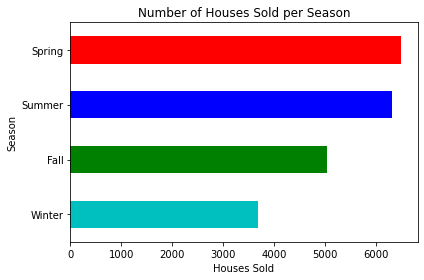

In [14]:
# Convert the dates to season. Now we know which season each house was sold in. 
# month = []
# for x in df['date']:
#     month.append(x.month)
# df['month'] = month
# df['season'] = df['month']%12 // 3 + 1
quart_dict={
            1:'Winter',
            2:'Winter',
            3:'Spring',
            4:'Spring',
            5:'Spring',
            6:'Summer',
            7:'Summer',
            8:'Summer',
            9:'Fall',
            10:'Fall',
            11:'Fall',
            12:'Winter'
            }
df['season']=df.sale_month.map(quart_dict)



# Visualize the amount of houses sold per season
print(df['season'].value_counts())
df['season'].value_counts().sort_values().plot(kind = 'barh', color=['c','g','b','r'])
plt.title('Number of Houses Sold per Season')
plt.xlabel('Houses Sold')
plt.ylabel('Season')
plt.tight_layout()

## Renovations

In [15]:
# Categorize renovation's ages (How recent was the house renovated?)
NO_RENO=-100
df['renovation_age']=df.apply(lambda r:r.sale_year-r.yr_renovated if r.yr_renovated>0 else NO_RENO,axis=1)
def renovation_status(obs):
    s=''
    x=obs['renovation_age']
    if(x==NO_RENO):
        s='Never'
    elif(x>24):
        s='25+'
    elif(x>9):
        s='10-24'
    elif(x>4):
        s='5-9'
    elif(x>1):
        s='2-4'
    elif(x==1 or x==0 or x==-1):
        s='Recent'
    return s

df['renovation_status']=df.apply(renovation_status,axis=1)
df.renovation_status.value_counts()

Never     20791
10-24       260
25+         229
Recent      111
5-9         108
2-4          35
Name: renovation_status, dtype: int64

## Price Distribution

In [16]:
df['price'] = df['price'] / 1000

In [17]:
price_mean = df['price'].mean()
price_std = df['price'].std()
price_mean, price_std

(540.057663833937, 366.0595812312963)

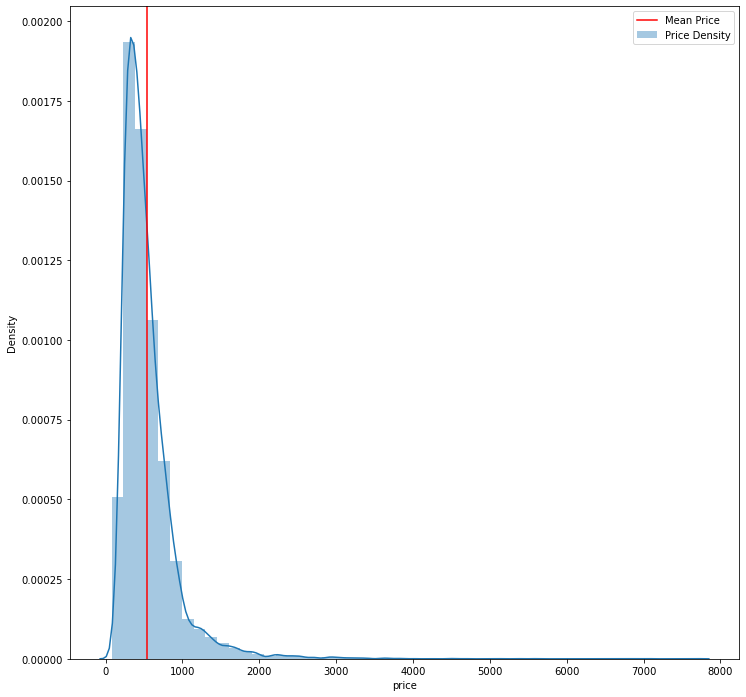

In [18]:
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.distplot(df['price'], label='Price Density')
plt.axvline(price_mean, color='red', label='Mean Price')
plt.legend()

In [19]:
avg_price_yr=df.groupby(['yr_built']).price.mean()
avg_price_yr.sort_index()

yr_built
1900    581.536632
1901    557.108345
1902    673.192593
1903    480.958196
1904    583.867756
           ...    
2011    544.648385
2012    527.436982
2013    678.811430
2014    683.923703
2015    759.970947
Name: price, Length: 116, dtype: float64

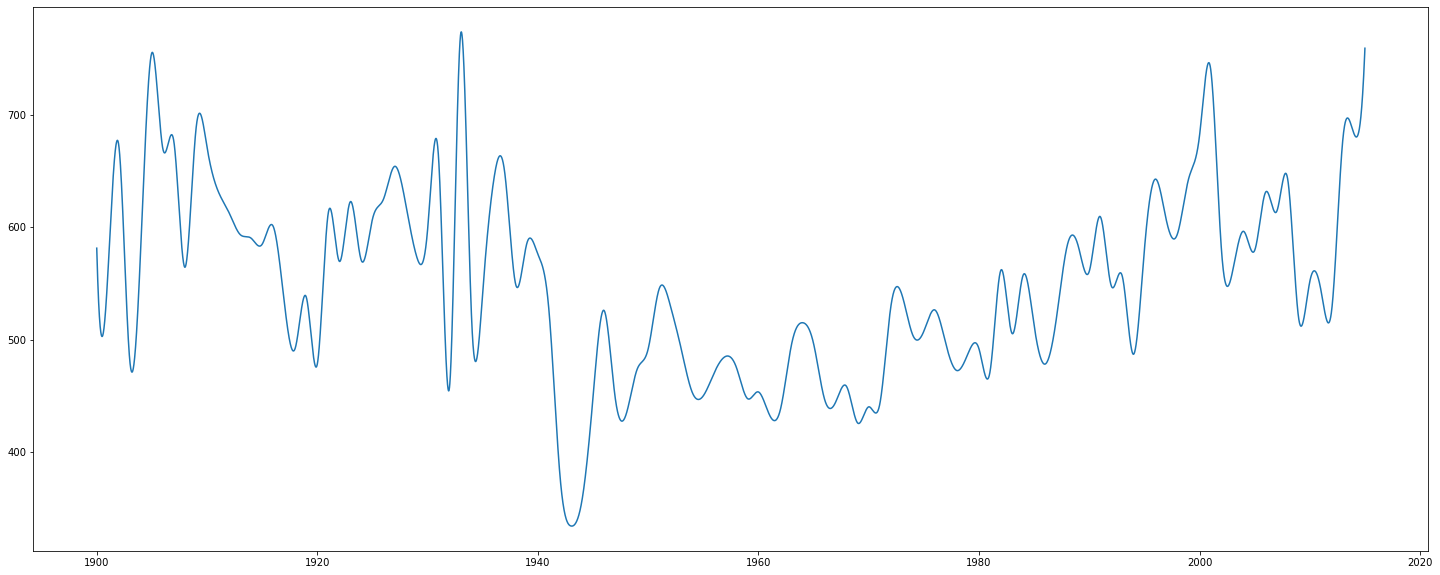

In [20]:
# Interpolate to make more smooth
T=avg_price_yr.index
X=np.linspace(T.min(),T.max(),10000)
Y=avg_price_yr.values
spl=interpolate.make_interp_spline(T,Y,3)
test=spl(X)

fig,ax=plt.subplots(figsize=(25,10))
ax.plot(X,test)

Text(0.5, 1.0, 'House price boxplot')

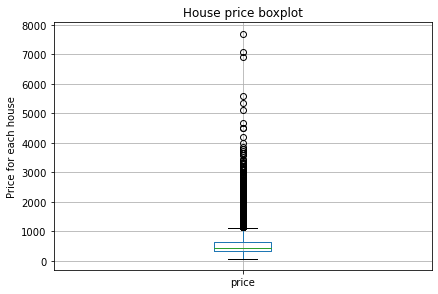

In [21]:
df.boxplot('price')
plt.tight_layout()
plt.ylabel('Price for each house')
plt.title('House price boxplot')

## Floors

Text(0.5, 1.0, 'Avg Prices per Floor #')

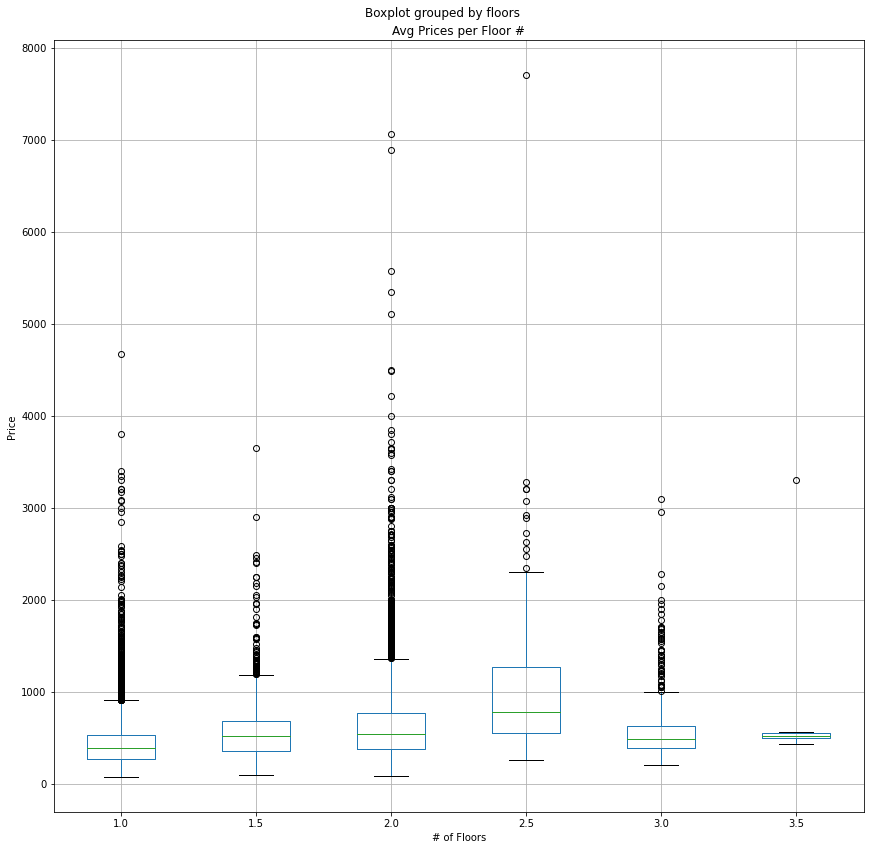

In [22]:
df['floors']
df.boxplot('price', by='floors', figsize=(12,12))
plt.tight_layout()
plt.ylabel('Price')
plt.xlabel('# of Floors')
plt.title('Avg Prices per Floor #')

1.0    10643
2.0     8211
1.5     1903
3.0      611
2.5      159
3.5        7
Name: floors, dtype: int64


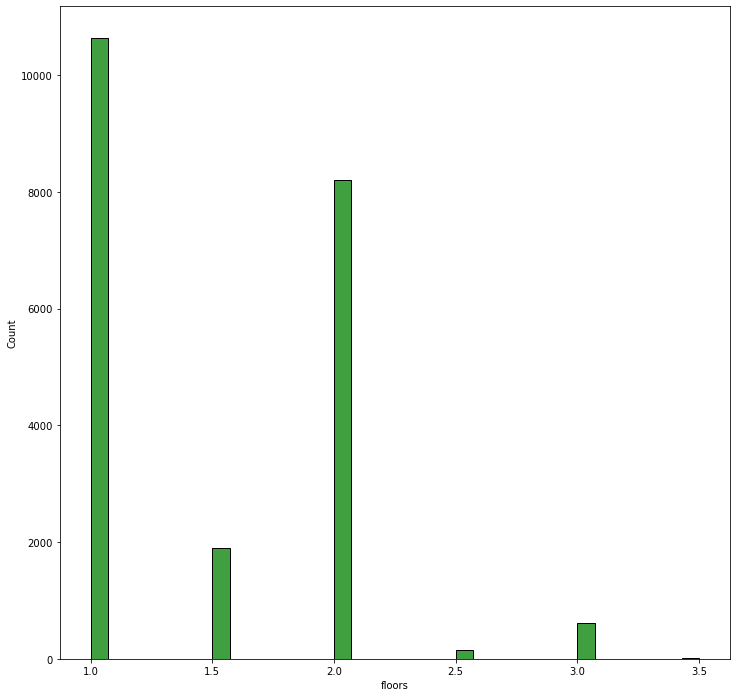

In [23]:
# For each number of floors, how many house sales were there? So how many 1 floor houses were sold? 2 floor? etc...
fig, axes = plt.subplots(figsize=(12,12))
sns.histplot(df['floors'], color = 'green')
print(df['floors'].value_counts())

## Sqft_living

price          1.000000
sqft_living    0.701587
Name: price, dtype: float64

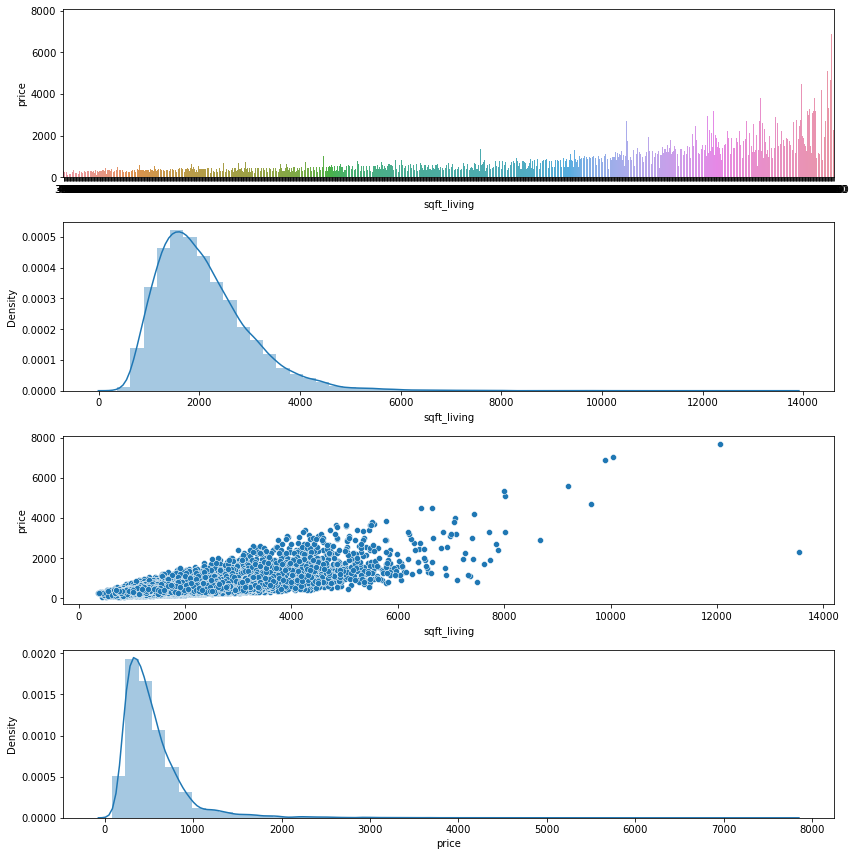

In [24]:
# Bar plot of sqft_living to price
fig, axes = plt.subplots(4,1, figsize=(12,12))

sns.barplot(x='sqft_living', y='price', data=df, ci=None, ax = axes[0])



sns.distplot(df['sqft_living'], ax=axes[1])



sns.distplot(df['price'], ax=axes[3])


sns.scatterplot(x='sqft_living', y='price', data=df, ci=None, ax = axes[2])

plt.tight_layout()
# The average of the living square feet is displayed with a red line on the pdf graph

# The results indicate a clear correlation between the living space size and the price. As living space size goes up, generally so does price.

# The strong correlation coefficient between the two variables helps validate this claim
df.corr()['price'][df.corr()['price'] >= .70]



In [25]:
df['sqft_outside']=df['sqft_lot']-df['sqft_living']
df['sqft_outside15']=df['sqft_lot15']-df['sqft_living15']
df['percent_above']=df.sqft_above/df.sqft_living
df['percent_above']

id
7129300520    1.000000
6414100192    0.844358
5631500400    1.000000
2487200875    0.535714
1954400510    1.000000
                ...   
263000018     1.000000
6600060120    1.000000
1523300141    1.000000
291310100     1.000000
1523300157    1.000000
Name: percent_above, Length: 21534, dtype: float64

## Targets and Features

In [26]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_lot15,sale_year,sale_month,age,season,renovation_age,renovation_status,sqft_outside,sqft_outside15,percent_above
id,,,,,,,,,,,,,,,,,,,,,
7129300520,2014-10-13,221.9,3,1.00,1180,5650,1.0,0.0,0.0,3,...,5650,2014,10,59,Fall,-100.0,Never,4470,4310,1.000000
6414100192,2014-12-09,538.0,3,2.25,2570,7242,2.0,0.0,0.0,3,...,7639,2014,12,63,Winter,23.0,10-24,4672,5949,0.844358
5631500400,2015-02-25,180.0,2,1.00,770,10000,1.0,0.0,0.0,3,...,8062,2015,2,82,Winter,-100.0,Never,9230,5342,1.000000
2487200875,2014-12-09,604.0,4,3.00,1960,5000,1.0,0.0,0.0,5,...,5000,2014,12,49,Winter,-100.0,Never,3040,3640,0.535714
1954400510,2015-02-18,510.0,3,2.00,1680,8080,1.0,0.0,0.0,3,...,7503,2015,2,28,Winter,-100.0,Never,6400,5703,1.000000


In [27]:
#Lets set the category_factors to datatype category....
df.sale_yr=df.sale_year.astype('category')
df.waterfront=df.waterfront.astype('category')
df.condition=df.condition.astype('category')
df.season=df.season.astype('category')

<ipython-input-27-98b7ea1f6e10>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.sale_yr=df.sale_year.astype('category')


In [28]:
#splitting up the dataframe between target and factors, further organized by type.
target=['price']
dense_factors=['sqft_living','sqft_outside','percent_above','sqft_living15','sqft_outside15','age']
sparse_factors=['bedrooms','bathrooms','floors','view','grade','condition']
ordinal_factors=['renovation_status']
category_factors=['season','waterfront']
other=['zipcode','lat','long','month','day','sale_year']

AxesSubplot(0.125,0.125;0.62x0.755)


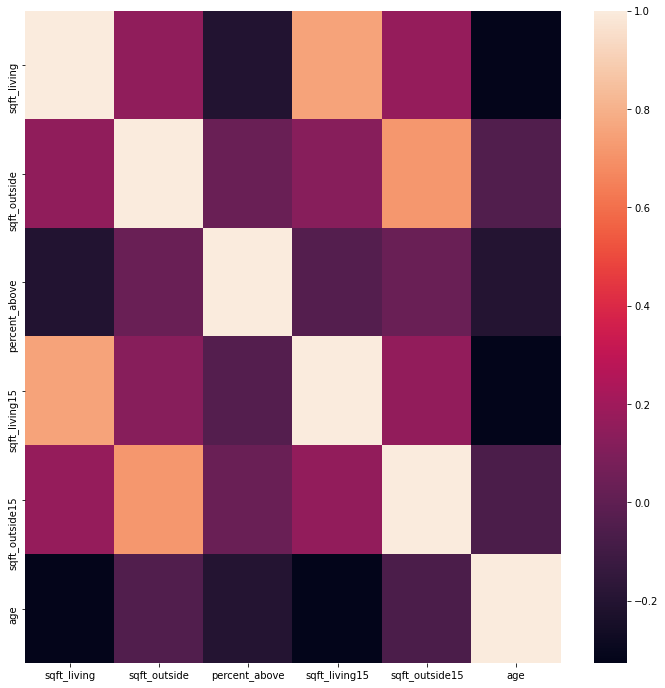

In [29]:
# Preliminary collinearity check
fig, ax = plt.subplots(figsize=(12,12))
print(sns.heatmap(df[dense_factors].corr(), ax=ax))

## Outliers

In [30]:
## Outliers
#Want to look at variables which are not categorical.
df_quant=df[target+dense_factors+sparse_factors]
#Calculate Z_Scores for all the quantitative columns.
df_zScores=df_quant.apply(stats.zscore)
df_zScores.head()

,price,sqft_living,sqft_outside,percent_above,sqft_living15,sqft_outside15,age,bedrooms,bathrooms,floors,view,grade,condition
id,,,,,,,,,,,,,
7129300520,-0.869162,-0.980819,-0.207151,0.728030,-0.943359,-0.237857,0.533735,-0.402680,-1.451646,-0.915398,-0.305436,-0.560649,-0.629726
6414100192,-0.005621,0.534291,-0.202251,-0.182470,-0.432488,-0.177461,0.669894,-0.402680,0.174721,0.937163,-0.305436,-0.560649,-0.629726
5631500400,-0.983627,-1.427722,-0.091700,0.728030,1.070931,-0.199828,1.316651,-1.482141,-1.451646,-0.915398,-0.305436,-1.413443,-0.629726
2487200875,0.174681,-0.130613,-0.241834,-1.988023,-0.914166,-0.262547,0.193337,0.676781,1.150541,-0.915398,-0.305436,-0.560649,2.444177
1954400510,-0.082113,-0.435815,-0.160340,0.728030,-0.271929,-0.186526,-0.521500,-0.402680,-0.150553,-0.915398,-0.305436,0.292146,-0.629726


In [31]:
#Define an extreme threshold.  Z-Scores above this threshold will be flagged.
threshold=10
out_bool=df_zScores.apply(lambda x:abs(x)>threshold)
out_bool['totals']=out_bool.apply(sum,axis=1)
out_bool.sum()

price             10
sqft_living        2
sqft_outside      35
percent_above      0
sqft_living15      0
sqft_outside15    28
age                0
bedrooms           1
bathrooms          0
floors             0
view               0
grade              0
condition          0
totals            76
dtype: int64

In [32]:
#We can choose to drop all observations which have 1 or two extreme values.
outliers=out_bool.totals.nlargest(67)
df_clean=df.drop(outliers.index.values,axis=0)
df_clean.shape

(21467, 29)

## Grade

Text(0.5, 1.0, 'Price per Grade')

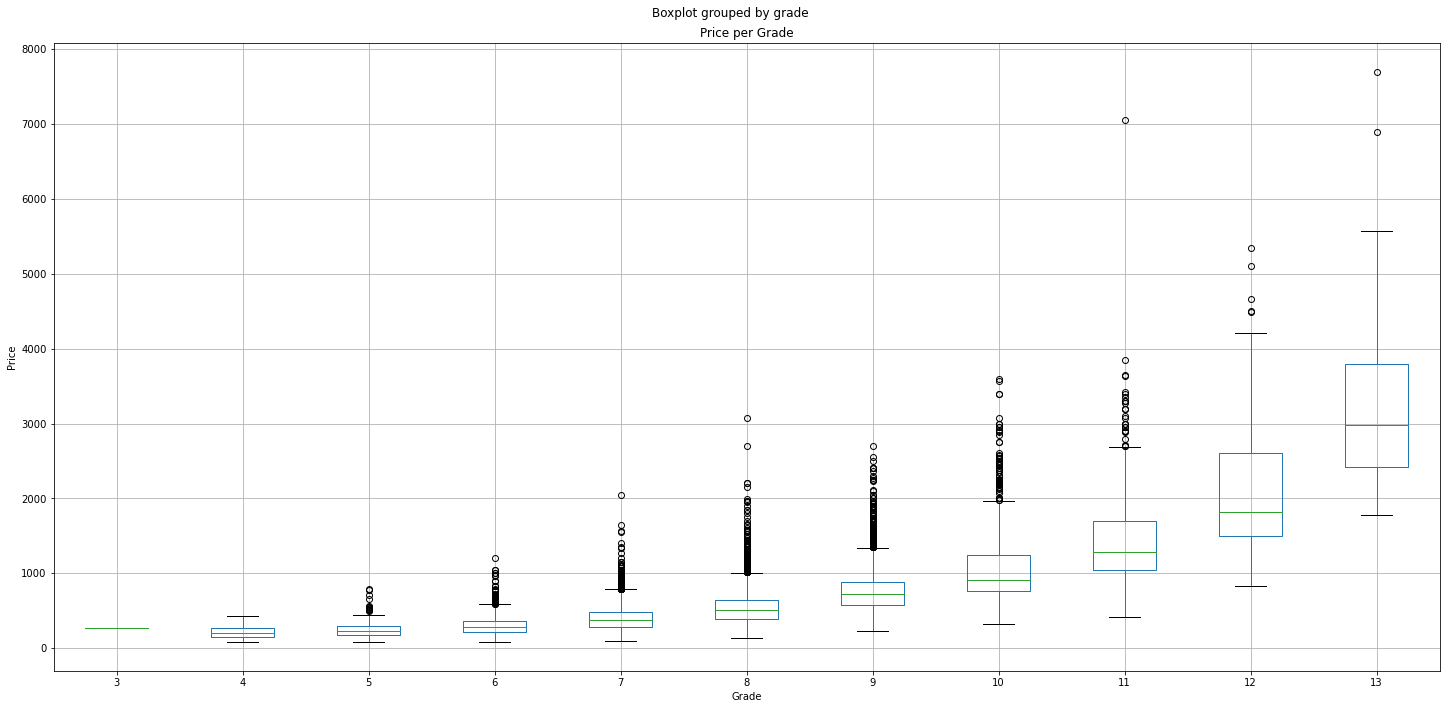

In [33]:
df.boxplot('price', by='grade', figsize=(20,10))
plt.tight_layout()
plt.ylabel('Price')
plt.xlabel('Grade')
plt.title('Price per Grade')

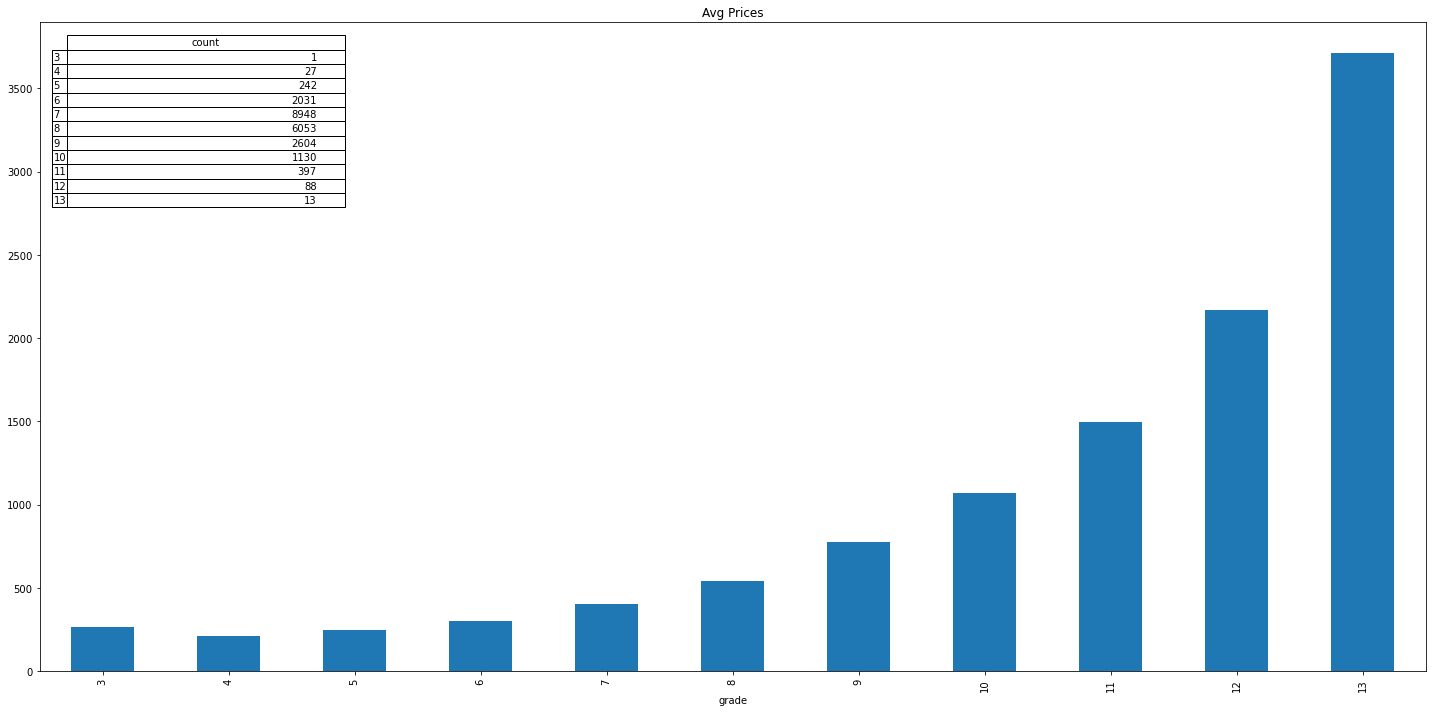

In [34]:
grouped_prices=df.groupby('grade').price
mean_count=grouped_prices.agg(['mean','count'])

fig,ax=plt.subplots(figsize=(20,10))
ax.set_title('Avg Prices')
pd.plotting.table(ax,mean_count[['count']],loc='upper left',colWidths=[0.2,0.2])
mean_count['mean'].plot(kind='bar',ax=ax)

plt.tight_layout()

<AxesSubplot:xlabel='grade', ylabel='price'>

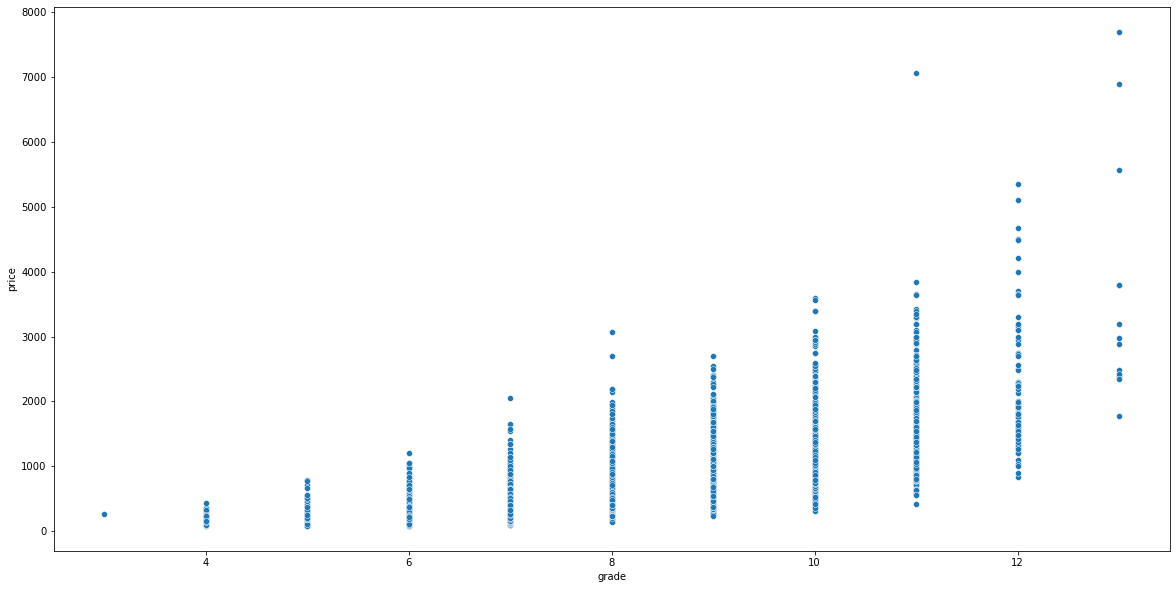

In [35]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(x='grade', y='price', data=df, ci=None, ax=ax)

## Bedrooms, bathrooms

Text(0.5, 1.0, 'Price per Bedroom #')

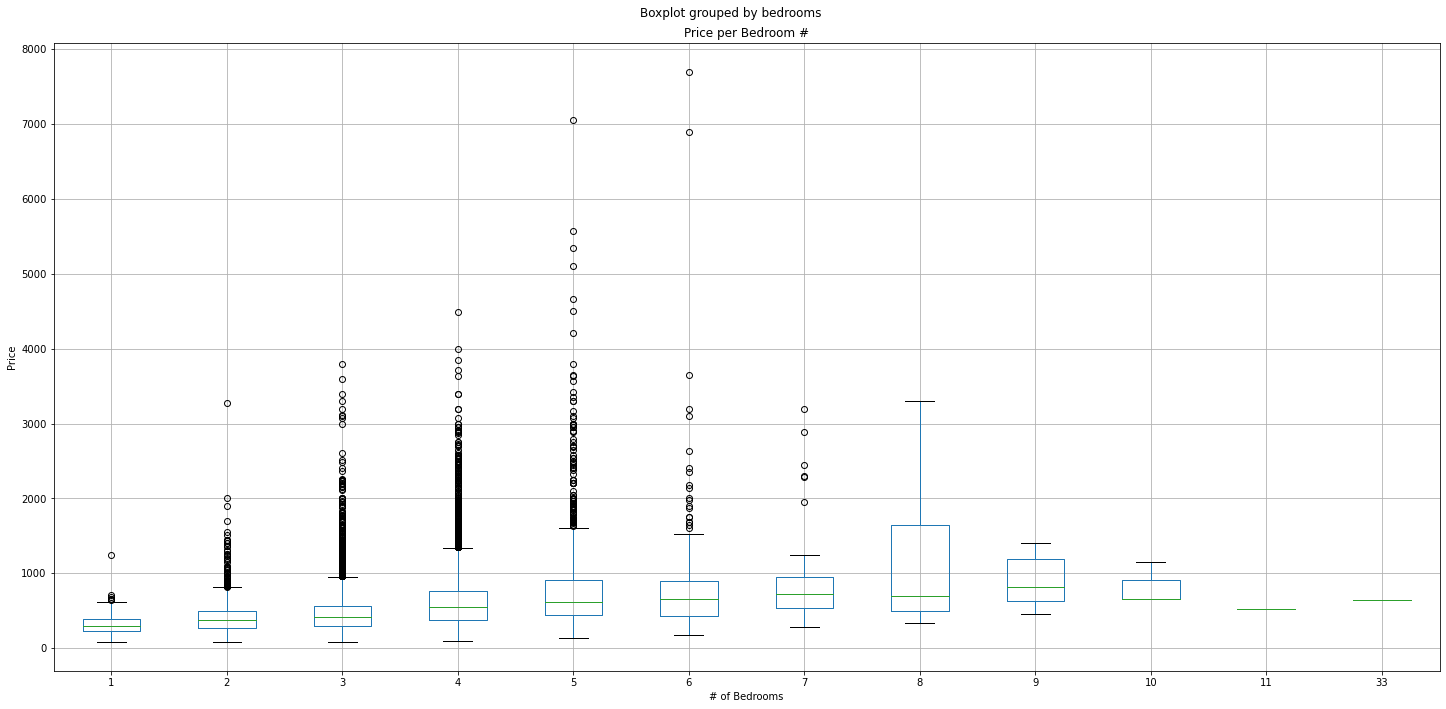

In [36]:
df.boxplot('price', by='bedrooms', figsize=(20,10))
plt.tight_layout()
plt.ylabel('Price')
plt.xlabel('# of Bedrooms')
plt.title('Price per Bedroom #')

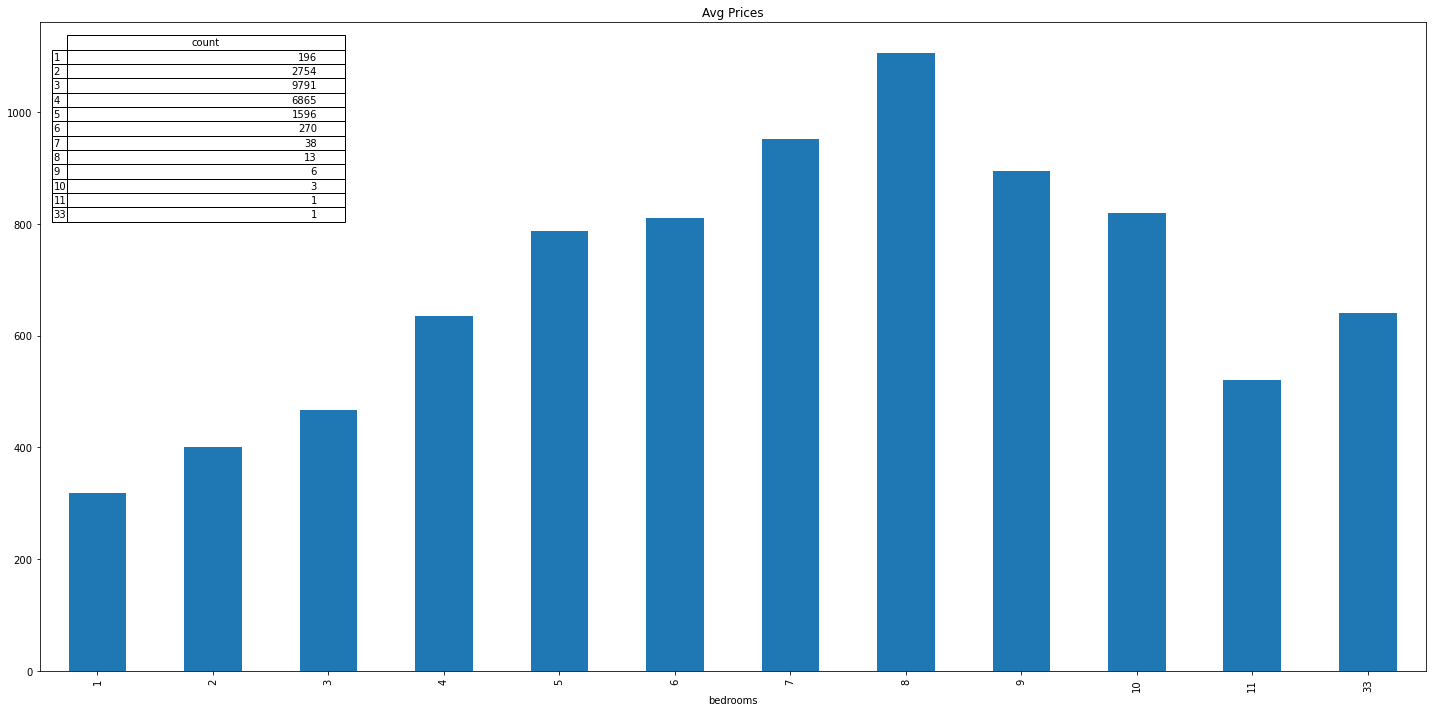

In [37]:
grouped_prices=df.groupby('bedrooms').price
mean_count=grouped_prices.agg(['mean','count'])

fig,ax=plt.subplots(figsize=(20,10))
ax.set_title('Avg Prices')
pd.plotting.table(ax,mean_count[['count']],loc='upper left',colWidths=[0.2,0.2])
mean_count['mean'].plot(kind='bar',ax=ax)

plt.tight_layout()

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

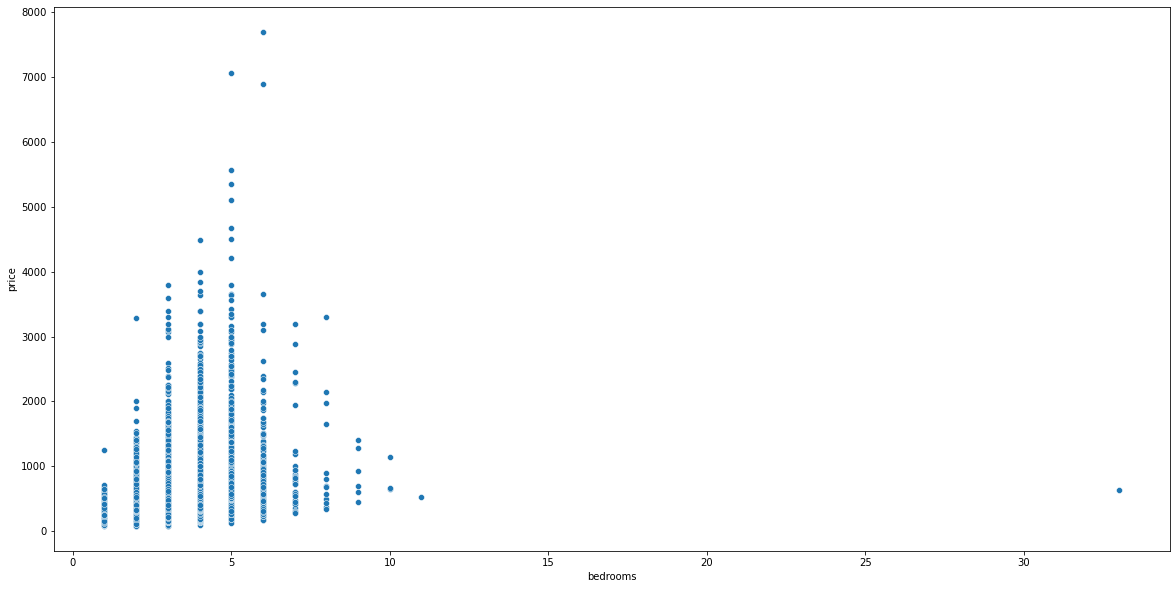

In [38]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(x='bedrooms', y='price', data=df, ci=None, ax=ax)

Text(0.5, 1.0, 'Price per Bathroom #')

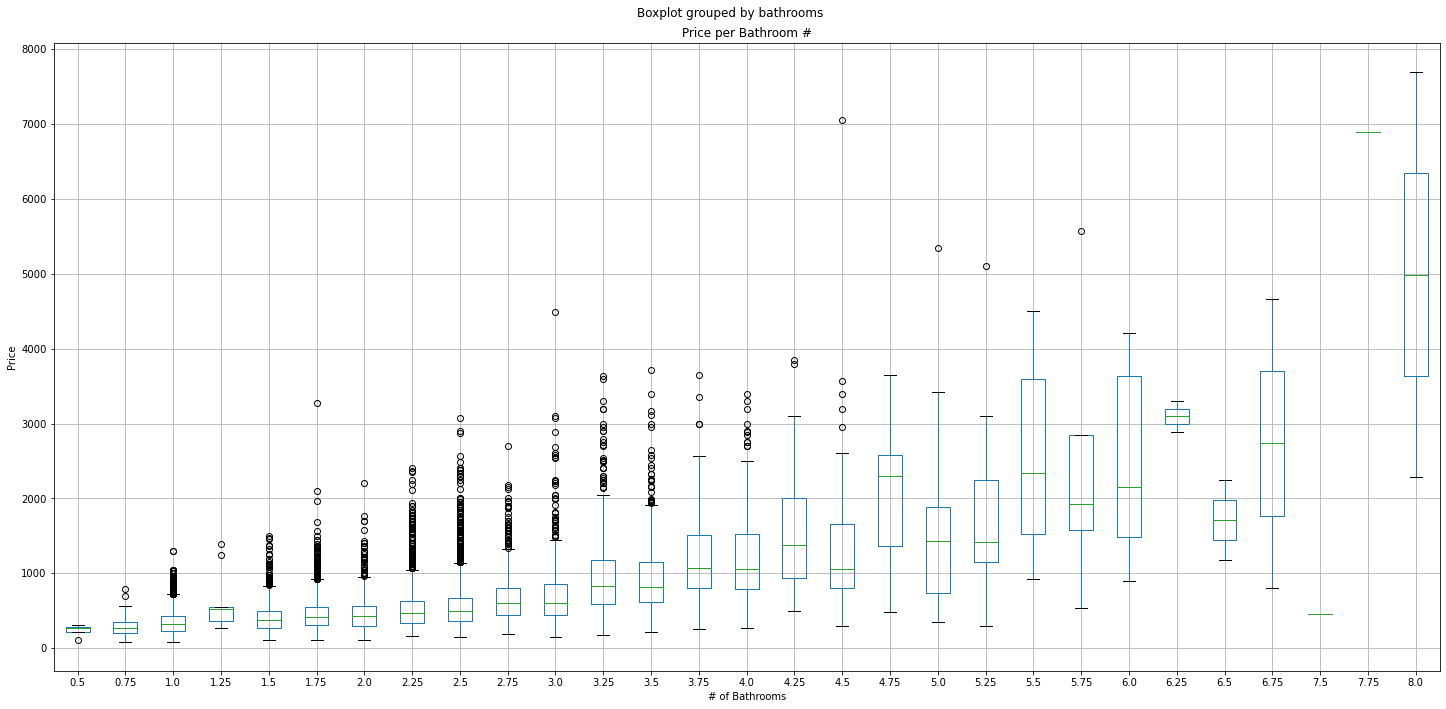

In [39]:
df.boxplot('price', by='bathrooms', figsize=(20,10))
plt.tight_layout()
plt.ylabel('Price')
plt.xlabel('# of Bathrooms')
plt.title('Price per Bathroom #')

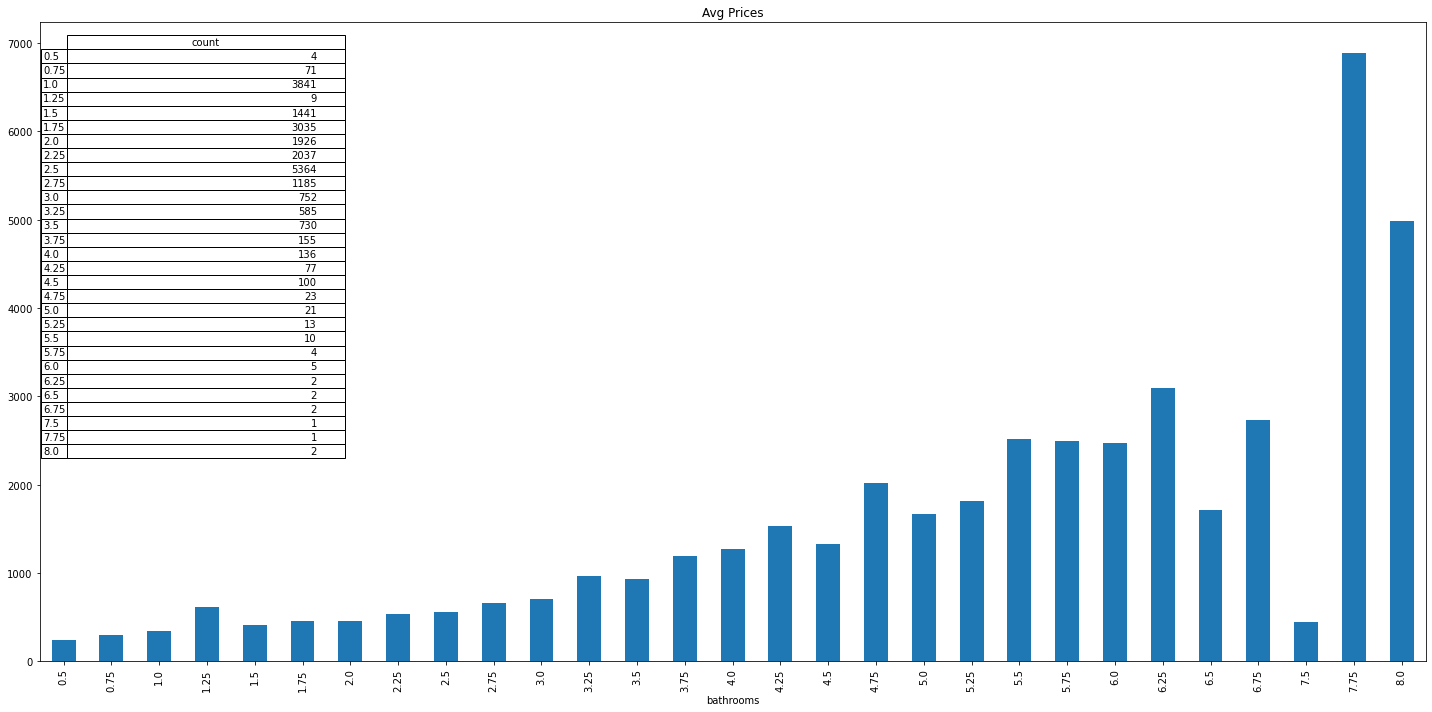

In [40]:
grouped_prices=df.groupby('bathrooms').price
mean_count=grouped_prices.agg(['mean','count'])

fig,ax=plt.subplots(figsize=(20,10))
ax.set_title('Avg Prices')
pd.plotting.table(ax,mean_count[['count']],loc='upper left',colWidths=[0.2,0.2])
mean_count['mean'].plot(kind='bar',ax=ax)

plt.tight_layout()

<AxesSubplot:xlabel='bathrooms', ylabel='price'>

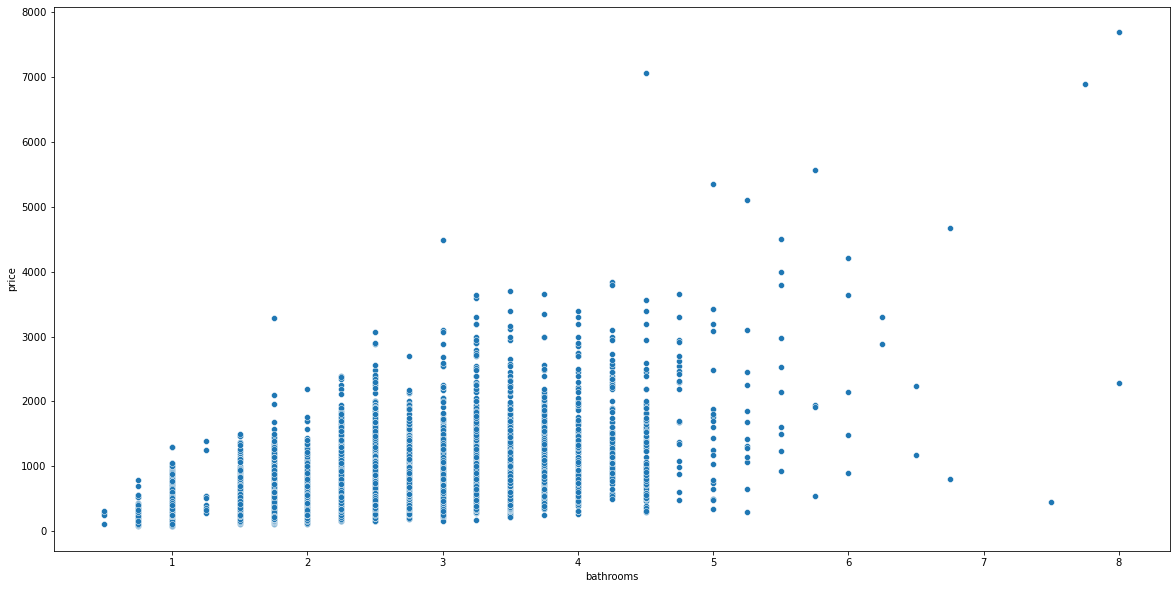

In [41]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(x='bathrooms', y='price', data=df, ci=None, ax=ax)

## Condition

Text(0.5, 1.0, 'Avg price by condition')

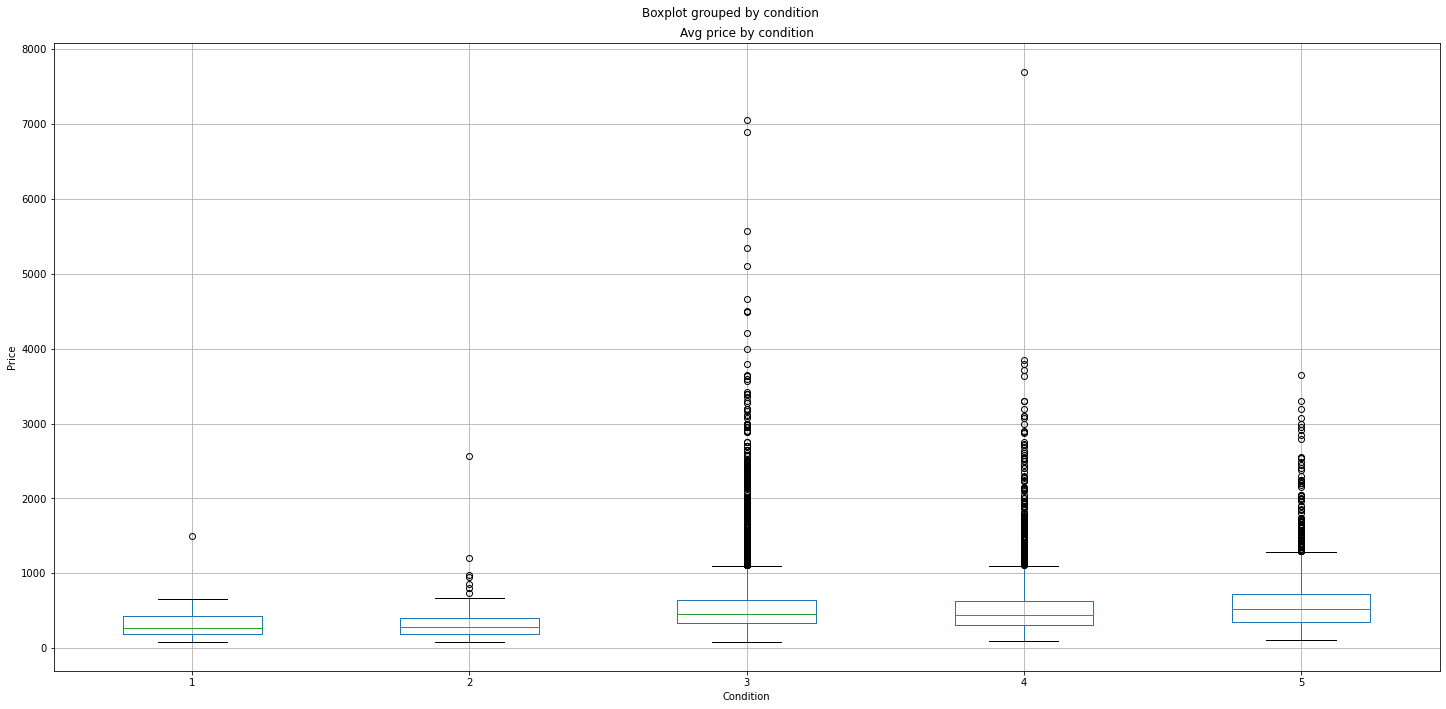

In [42]:
df.boxplot('price', by='condition', figsize=(20,10))
plt.tight_layout()
plt.ylabel('Price')
plt.xlabel('Condition')
plt.title('Avg price by condition')

<AxesSubplot:xlabel='condition', ylabel='price'>

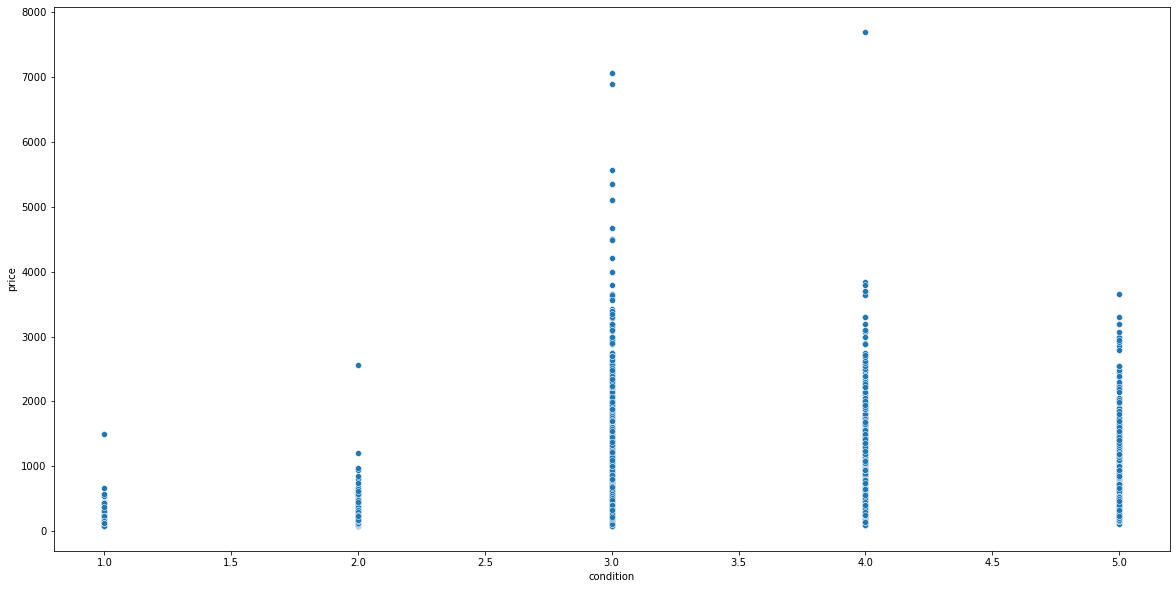

In [43]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(x='condition', y='price', data=df, ci=None, ax=ax)

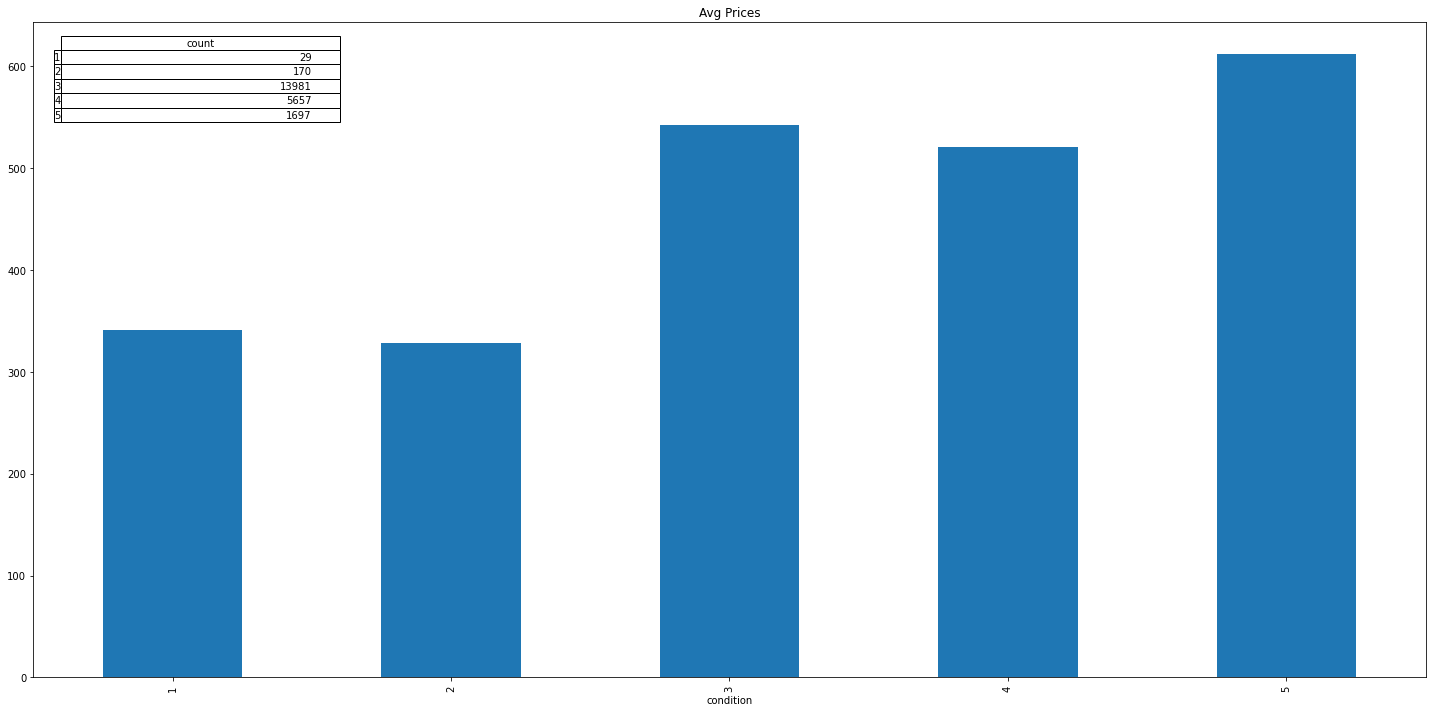

In [44]:
grouped_prices=df.groupby('condition').price
mean_count=grouped_prices.agg(['mean','count'])

fig,ax=plt.subplots(figsize=(20,10))
ax.set_title('Avg Prices')
pd.plotting.table(ax,mean_count[['count']],loc='upper left',colWidths=[0.2,0.2])
mean_count['mean'].plot(kind='bar',ax=ax)

plt.tight_layout()

## Renovation Status

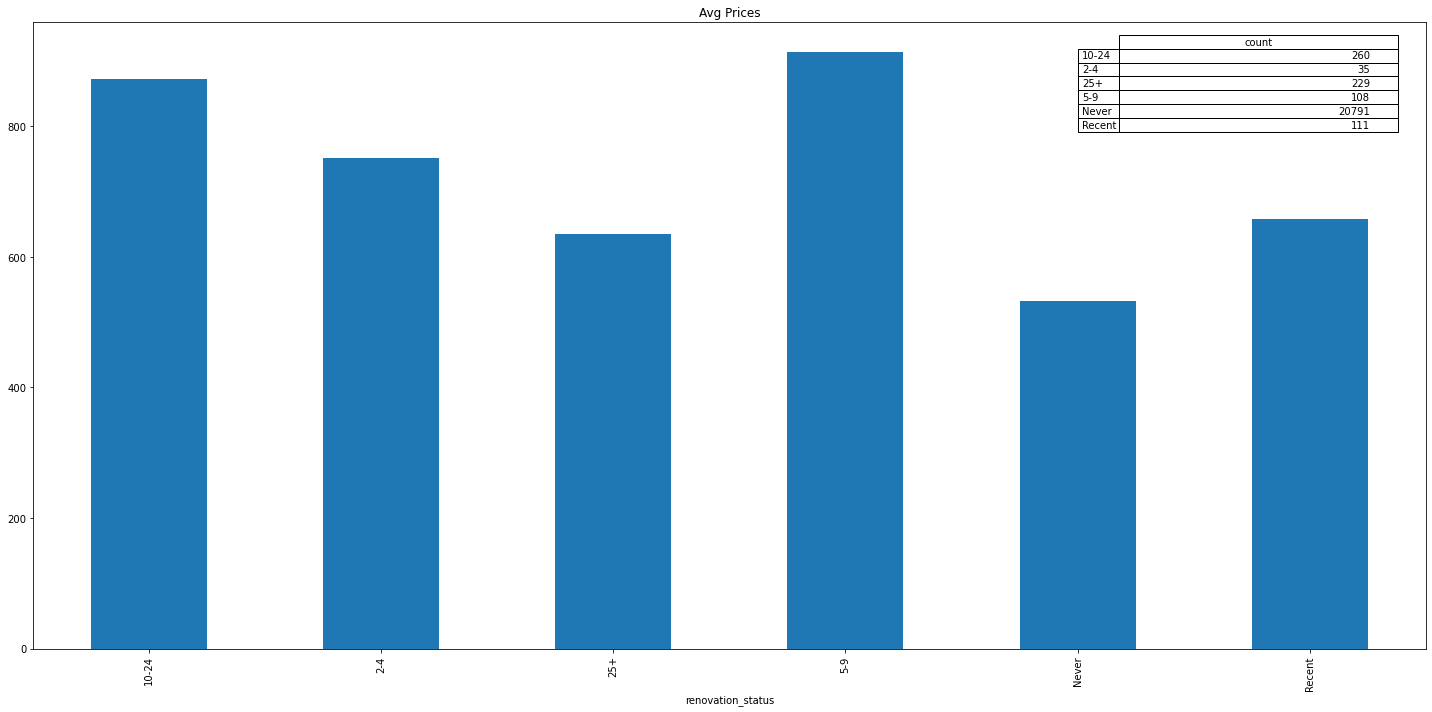

In [45]:
grouped_prices=df.groupby('renovation_status').price
mean_count=grouped_prices.agg(['mean','count'])

fig,ax=plt.subplots(figsize=(20,10))
ax.set_title('Avg Prices')
pd.plotting.table(ax,mean_count[['count']],loc='upper right',colWidths=[0.2,0.2])
mean_count['mean'].plot(kind='bar',ax=ax)

plt.tight_layout()

Text(0.5, 1.0, 'Avg price by Renovation Status')

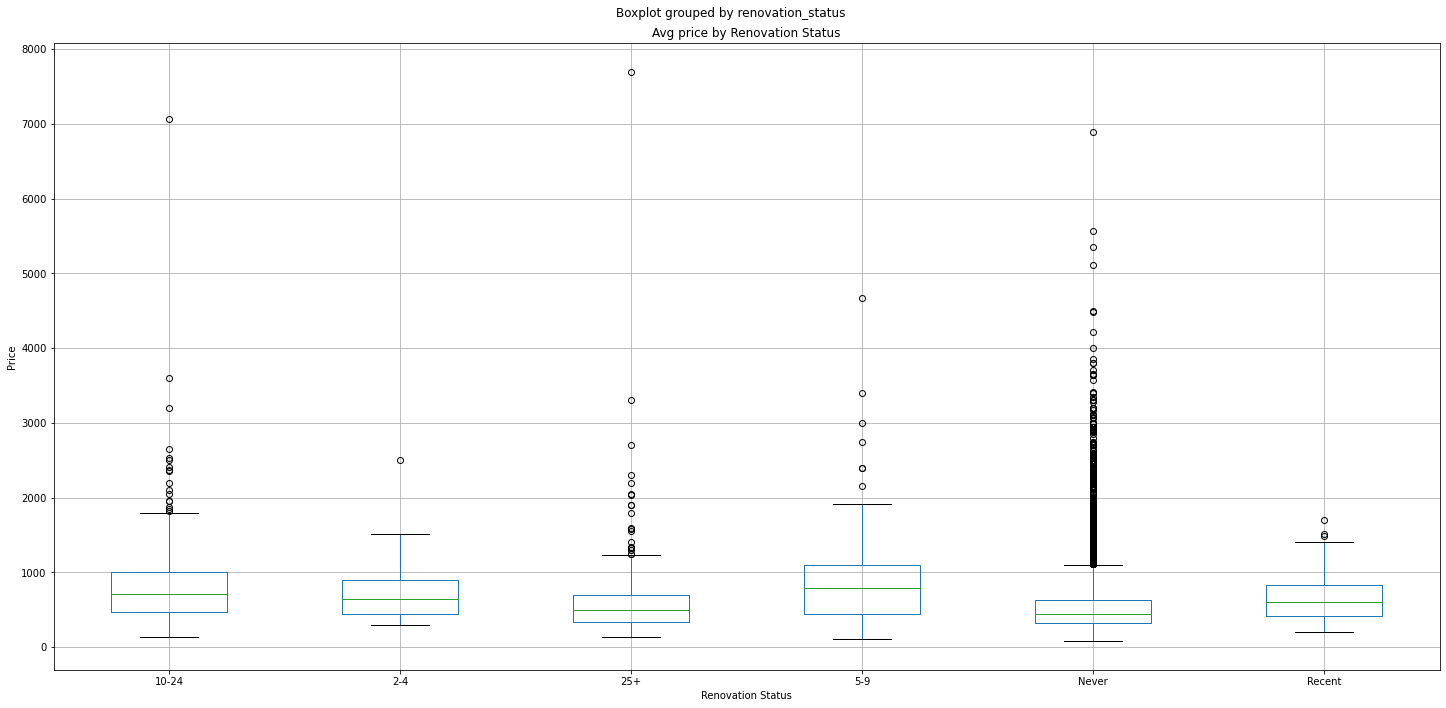

In [46]:
df.boxplot('price', by='renovation_status', figsize=(20,10))
plt.tight_layout()
plt.ylabel('Price')
plt.xlabel('Renovation Status')
plt.title('Avg price by Renovation Status')

<AxesSubplot:xlabel='renovation_status', ylabel='price'>

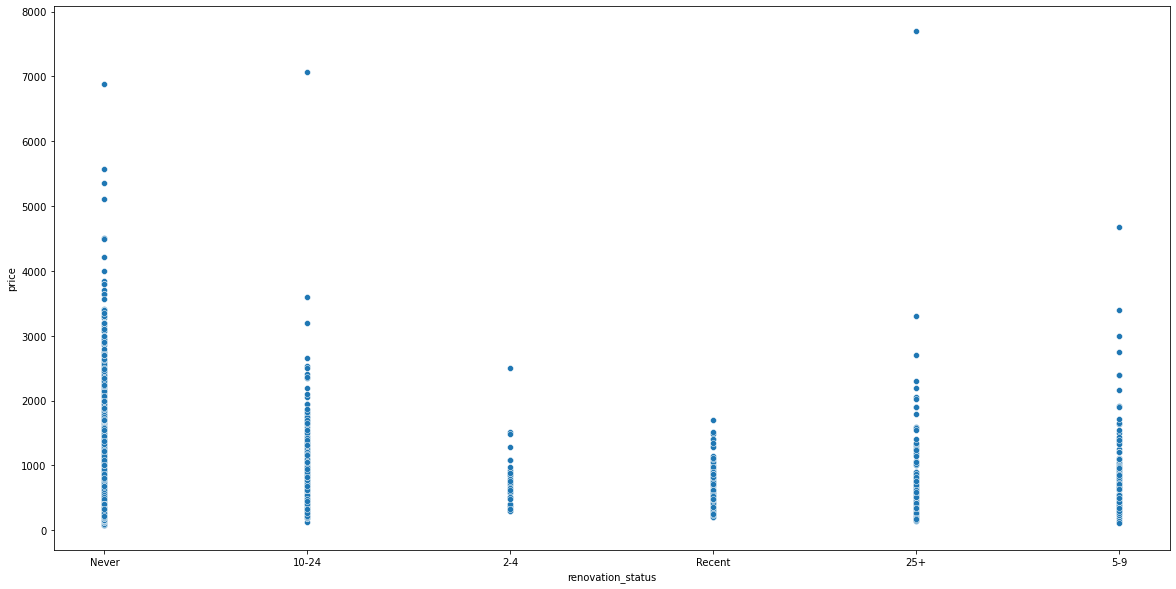

In [47]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(x='renovation_status', y='price', data=df, ci=None, ax=ax)

## Sqft_lot

<AxesSubplot:xlabel='sqft_lot', ylabel='Density'>

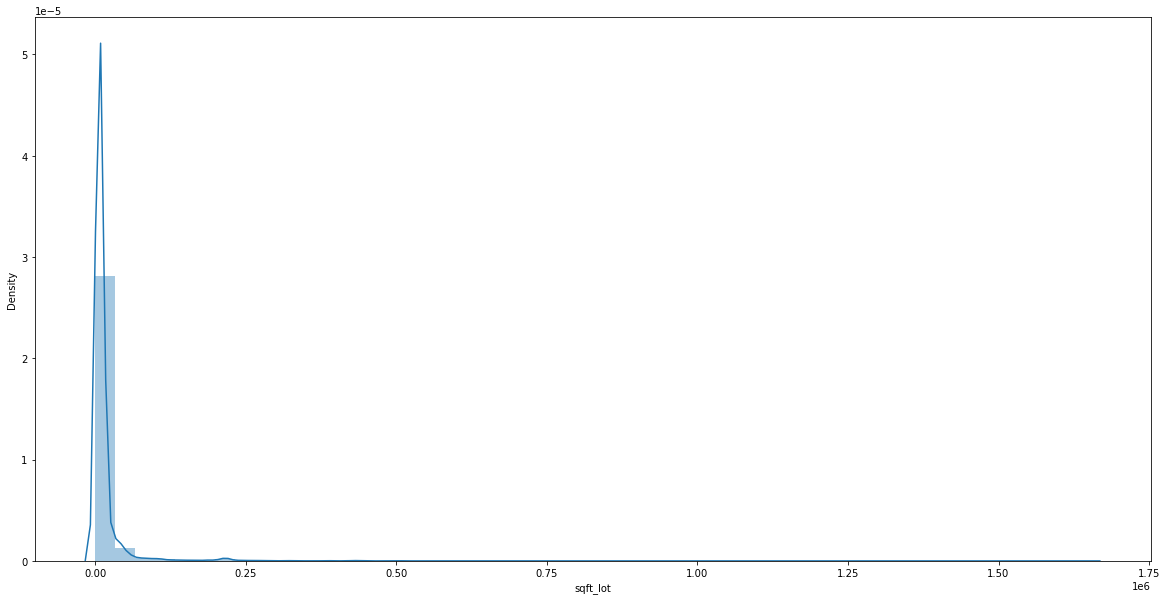

In [59]:
fig, axes = plt.subplots(figsize=(20,10))
sns.distplot(df['sqft_lot'])

<AxesSubplot:xlabel='sqft_lot', ylabel='price'>

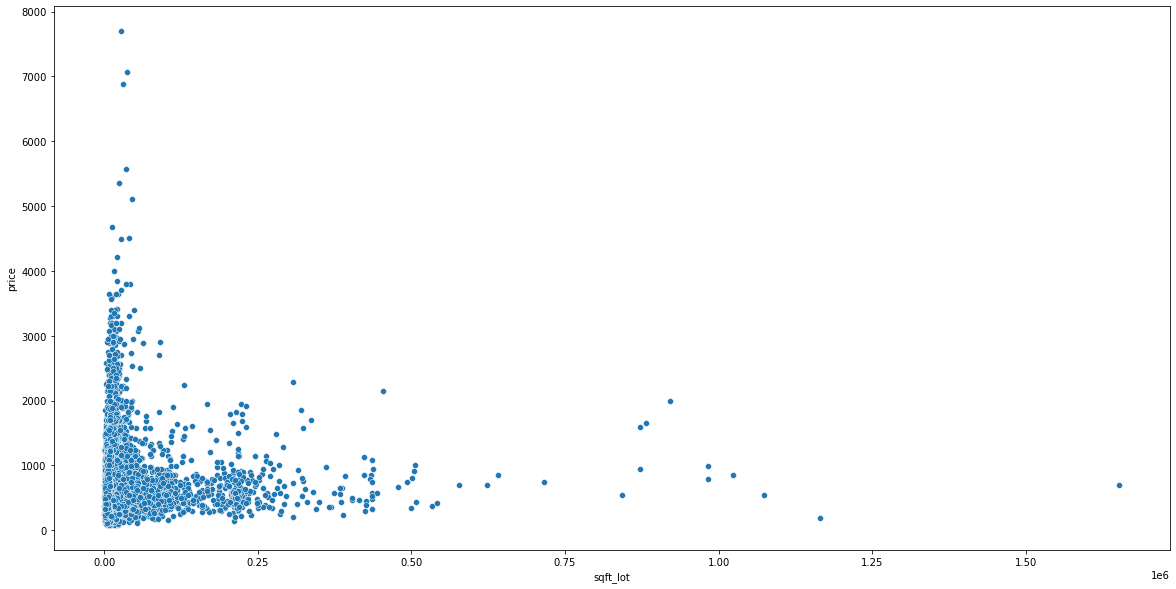

In [60]:
fig, axes = plt.subplots(figsize=(20,10))
sns.scatterplot(x='sqft_lot', y='price', data=df, ci=None)

## Sqft_outside

<AxesSubplot:xlabel='sqft_outside', ylabel='Density'>

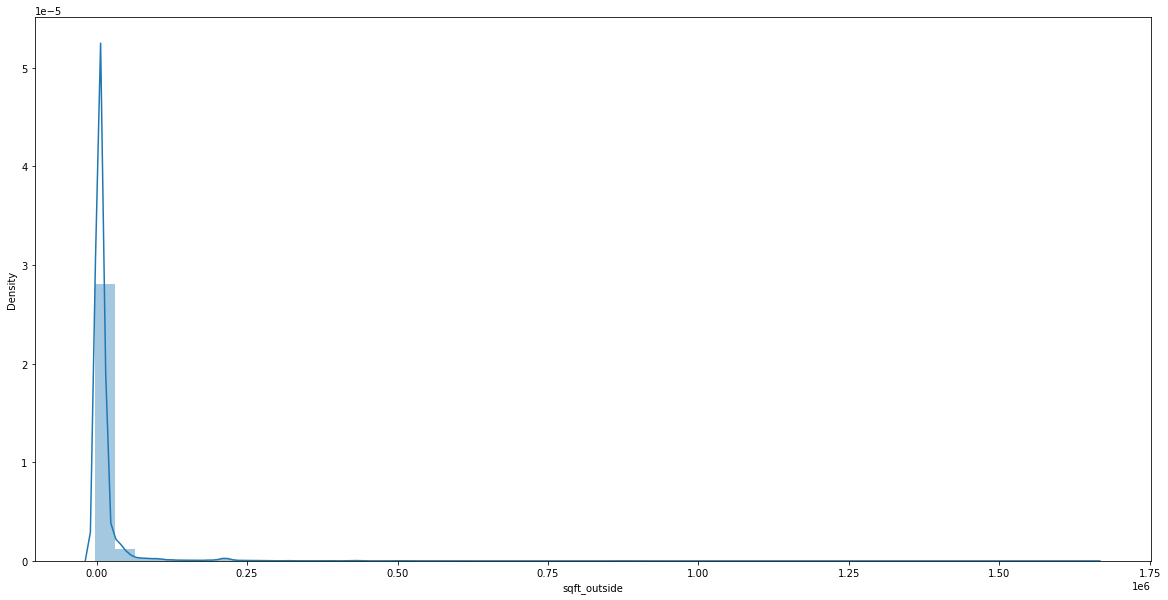

In [62]:
fig, axes = plt.subplots(figsize=(20,10))
sns.distplot(df['sqft_outside'])

<AxesSubplot:xlabel='sqft_outside', ylabel='price'>

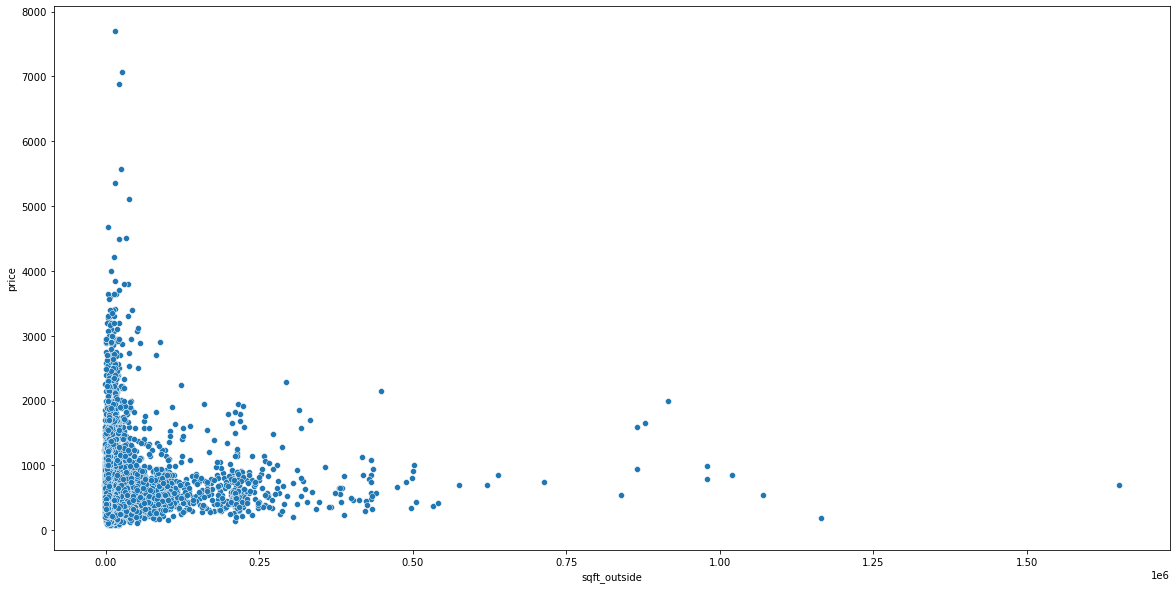

In [63]:
fig, axes = plt.subplots(figsize=(20,10))
sns.scatterplot(x='sqft_outside', y='price', data=df, ci=None)

## Regression

First task at this stage is to translate our categorical variables into dummy variables.

In [50]:
cats_df=df.copy()
dummies=[]
ohe = OneHotEncoder(drop='first')
for c in category_factors:
#cat='season'
    cat_trans = ohe.fit_transform(df[[c]])
    cat_df = pd.DataFrame(cat_trans.todense(), columns=ohe.get_feature_names(),index=df.index)
    cats_df=pd.merge(cats_df,cat_df,right_index=True,left_index=True,how='outer')
    dummies.extend(ohe.get_feature_names())

In [51]:
print(cat_df.shape)
print(cats_df.shape)
print(df.shape)
dummies

(21534, 1)
(22608, 33)
(21534, 29)


['x0_Spring', 'x0_Summer', 'x0_Winter', 'x0_1.0']

Next, we need to encode our ordinal data in a similar fashion.  But we must provide some ordinal measures to the renovation variable.

In [52]:
######?????

Now, we want to consider polynomial values for square foot living and square foot outside

In [53]:
df['sqft_living2']=df['sqft_living']**2
dense_factors.append('sqft_living2')

Before diving into the true model.  It may be helpful to look at some preliminary regressions

[[0.27993212]]


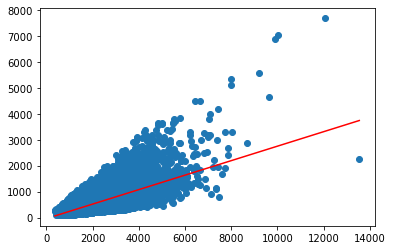

In [54]:
lr=LinearRegression()
lr.fit(df[['sqft_living']],df[target])
print(lr.coef_)
lr.score(df[['sqft_living']],df[target])
simple_test=[df[['sqft_living']].min(),df[['sqft_living']].max()]
simple_pred=lr.predict(simple_test)
fig,ax=plt.subplots()
ax.plot(simple_test,simple_pred,color='red')
ax.scatter(df['sqft_living'],df[target])

In [55]:
lr=LinearRegression()
lr.fit(cats_df[['x0_Spring','x0_Summer','x0_Winter']],cats_df[target])
lr.score(cats_df[['x0_Spring','x0_Summer','x0_Winter']],cats_df[target])

0.0012873499640940755

In [56]:
def forward_steps(data,Y,X):
    dependent=data[Y]
    Models=[[]]
    features=X.copy()
    lr=LinearRegression()
    def r_score_margin(original,new_f):
        X_Y=(data[original+[new_f]],dependent)
        lr.fit(*X_Y)
        return lr.score(*X_Y)
    while len(features)>0:
        M=Models[-1]
        new_f=max(features,key=lambda f: r_score_margin(M,f))
        features.remove(new_f)
        Models.append([new_f]+M)
    Models.remove([])
    return Models

def backward_steps(data,Y,X):
    dependent=data[Y]
    steps=len(X)
    Models=[X.copy()]
    lr=LinearRegression()
    def r_score_exmargin(original,new_f):
        ins=original.copy()
        ins.remove(new_f)
        X_Y=(data[ins],dependent)
        lr.fit(*X_Y)
        return lr.score(*X_Y)
    while steps>1:
        M=Models[-1].copy()
        worse_f=max(M,key=lambda f: r_score_exmargin(M,f))
        M.remove(worse_f)
        Models.append(M)
        steps-=1
    return Models

def subset_steps(data,Y,X):
    dimensions=X
    M=[]
    lr=LinearRegression()
    dependent=data[Y]
    def r_score_margin(inputs):
        X_Y=(data[inputs],dependent)
        lr.fit(*X_Y)
        return lr.score(*X_Y)
    for d in range(1,len(dimensions)+1):
        combos=[list(c) for c in combinations(dimensions,d)]
        top_model=max(combos,key=r_score_margin)
        M.append(top_model)
    return M

def CV_compare(data,Y,models,folds=5):
    scores={}
    lr=LinearRegression()
    state=random.randint(1,1000)
    SPLIT=KFold(folds,random_state=state,shuffle=True)
    for m in models:
        k='+'.join(m)
        scores[k]=cross_validate(lr,data[m],data[Y],cv=SPLIT)['test_score']
    return scores

In [57]:
fwd_models=forward_steps(df,target,(dense_factors+sparse_factors+dummies))
fwd_models

KeyError: "None of [Index(['x0_Spring'], dtype='object')] are in the [columns]"

In [ ]:
CV_compare(df,target,fwd_models)

{'sqft_living2': array([0.51826849, 0.49186634, 0.50603984, 0.51586603, 0.50078919]),
 'grade+sqft_living2': array([0.57032772, 0.55127023, 0.55789486, 0.57176582, 0.56070435]),
 'age+grade+sqft_living2': array([0.63546859, 0.61584869, 0.62711272, 0.62803554, 0.62763653]),
 'x0_1.0+age+grade+sqft_living2': array([0.66994378, 0.63615658, 0.65713   , 0.64866203, 0.64739346]),
 'view+x0_1.0+age+grade+sqft_living2': array([0.67606316, 0.64588185, 0.66459302, 0.65881739, 0.65622141]),
 'bathrooms+view+x0_1.0+age+grade+sqft_living2': array([0.68050672, 0.65140597, 0.66816789, 0.66317222, 0.65788108]),
 'bedrooms+bathrooms+view+x0_1.0+age+grade+sqft_living2': array([0.68326625, 0.65339052, 0.67048967, 0.66569096, 0.66076135]),
 'sqft_outside15+bedrooms+bathrooms+view+x0_1.0+age+grade+sqft_living2': array([0.684921  , 0.65437432, 0.67189123, 0.66793392, 0.66338967]),
 'sqft_living15+sqft_outside15+bedrooms+bathrooms+view+x0_1.0+age+grade+sqft_living2': array([0.68580241, 0.65597469, 0.67561179

In [ ]:
back_models=backward_steps(df,target,dense_factors+sparse_factors+dummies)
back_models

[['sqft_living',
  'sqft_outside',
  'percent_above',
  'sqft_living15',
  'sqft_outside15',
  'age',
  'sqft_living2',
  'bedrooms',
  'bathrooms',
  'floors',
  'view',
  'grade',
  'condition',
  'x0_Spring',
  'x0_Summer',
  'x0_Winter',
  'x0_1.0'],
 ['sqft_living',
  'sqft_outside',
  'percent_above',
  'sqft_living15',
  'sqft_outside15',
  'age',
  'sqft_living2',
  'bedrooms',
  'bathrooms',
  'floors',
  'view',
  'grade',
  'condition',
  'x0_Spring',
  'x0_Summer',
  'x0_1.0'],
 ['sqft_living',
  'sqft_outside',
  'percent_above',
  'sqft_living15',
  'sqft_outside15',
  'age',
  'sqft_living2',
  'bedrooms',
  'bathrooms',
  'floors',
  'view',
  'grade',
  'condition',
  'x0_Spring',
  'x0_1.0'],
 ['sqft_living',
  'percent_above',
  'sqft_living15',
  'sqft_outside15',
  'age',
  'sqft_living2',
  'bedrooms',
  'bathrooms',
  'floors',
  'view',
  'grade',
  'condition',
  'x0_Spring',
  'x0_1.0'],
 ['sqft_living',
  'sqft_living15',
  'sqft_outside15',
  'age',
  'sqft_

In [ ]:
CV_compare(df,target,back_models)

{'sqft_living+sqft_outside+percent_above+sqft_living15+sqft_outside15+age+sqft_living2+bedrooms+bathrooms+floors+view+grade+condition+x0_Spring+x0_Summer+x0_Winter+x0_1.0': array([0.69354155, 0.66660261, 0.66535827, 0.68151024, 0.67567623]),
 'sqft_living+sqft_outside+percent_above+sqft_living15+sqft_outside15+age+sqft_living2+bedrooms+bathrooms+floors+view+grade+condition+x0_Spring+x0_Summer+x0_1.0': array([0.69354712, 0.66660004, 0.66544813, 0.68173626, 0.67571009]),
 'sqft_living+sqft_outside+percent_above+sqft_living15+sqft_outside15+age+sqft_living2+bedrooms+bathrooms+floors+view+grade+condition+x0_Spring+x0_1.0': array([0.69350706, 0.66690401, 0.66544534, 0.68170319, 0.67569906]),
 'sqft_living+percent_above+sqft_living15+sqft_outside15+age+sqft_living2+bedrooms+bathrooms+floors+view+grade+condition+x0_Spring+x0_1.0': array([0.69349928, 0.66672203, 0.66584568, 0.68163829, 0.67552339]),
 'sqft_living+sqft_living15+sqft_outside15+age+sqft_living2+bedrooms+bathrooms+floors+view+grad

In [ ]:
sub_models=subset_steps(df,target,dense_factors+sparse_factors+dummies)
sub_models

[['sqft_living'],
 ['age', 'grade'],
 ['sqft_living', 'age', 'grade'],
 ['sqft_living', 'age', 'grade', 'x0_1.0'],
 ['sqft_living', 'age', 'view', 'grade', 'x0_1.0'],
 ['sqft_living', 'age', 'bathrooms', 'view', 'grade', 'x0_1.0'],
 ['sqft_living', 'age', 'bedrooms', 'bathrooms', 'view', 'grade', 'x0_1.0'],
 ['sqft_living',
  'sqft_outside15',
  'age',
  'bedrooms',
  'bathrooms',
  'view',
  'grade',
  'x0_1.0'],
 ['sqft_living',
  'sqft_living15',
  'sqft_outside15',
  'age',
  'bedrooms',
  'bathrooms',
  'view',
  'grade',
  'x0_1.0'],
 ['sqft_living',
  'sqft_living15',
  'sqft_outside15',
  'age',
  'bedrooms',
  'bathrooms',
  'view',
  'grade',
  'condition',
  'x0_1.0'],
 ['sqft_living',
  'sqft_living15',
  'sqft_outside15',
  'age',
  'bedrooms',
  'bathrooms',
  'floors',
  'view',
  'grade',
  'condition',
  'x0_1.0'],
 ['sqft_living',
  'sqft_living15',
  'sqft_outside15',
  'age',
  'bedrooms',
  'bathrooms',
  'floors',
  'view',
  'grade',
  'condition',
  'x0_Spring',

In [ ]:
CV_compare(cats_df,target,sub_models)

{'sqft_living': array([0.48954724, 0.47173606, 0.48637814, 0.4781497 , 0.48278568]),
 'age+grade': array([0.52398103, 0.5426704 , 0.52195019, 0.54760279, 0.54468306]),
 'sqft_living+age+grade': array([0.60480582, 0.60444763, 0.60416392, 0.60982412, 0.61077437]),
 'sqft_living+age+grade+x0_1.0': array([0.63270856, 0.62171146, 0.63447014, 0.64173792, 0.63797311]),
 'sqft_living+age+view+grade+x0_1.0': array([0.64277672, 0.63442934, 0.64245736, 0.64913536, 0.64786991]),
 'sqft_living+age+bathrooms+view+grade+x0_1.0': array([0.64434606, 0.63795305, 0.64658952, 0.65313416, 0.65085219]),
 'sqft_living+age+bedrooms+bathrooms+view+grade+x0_1.0': array([0.64803539, 0.64182682, 0.65259991, 0.65780512, 0.65675365]),
 'sqft_living+sqft_outside15+age+bedrooms+bathrooms+view+grade+x0_1.0': array([0.65002848, 0.64362097, 0.65392065, 0.65825334, 0.65919659]),
 'sqft_living+sqft_living15+sqft_outside15+age+bedrooms+bathrooms+view+grade+x0_1.0': array([0.65195397, 0.64332645, 0.65682229, 0.65970873, 0.6

In [ ]:
pf=PolynomialFeatures(2)
X=pd.DataFrame(pf.fit_transform(df[['sqft_living']]),columns=pf.get_feature_names()).drop('1',axis=1)
X

,x0,x0^2
0,1180.0,1392400.0
1,2570.0,6604900.0
2,770.0,592900.0
3,1960.0,3841600.0
4,1680.0,2822400.0
...,...,...
21462,1530.0,2340900.0
21463,2310.0,5336100.0
21464,1020.0,1040400.0
21465,1600.0,2560000.0


In [ ]:
lr=LinearRegression()
lr.fit(X,df[target])
lr.score(X,df[target])

0.5091582236646464

In [ ]:
pf.get_params()

{'degree': 2, 'include_bias': True, 'interaction_only': False, 'order': 'C'}

In [ ]:
df['sqft_living'].values.reshape(-1,1)